## Ethereum Stock Prices

* Import data
    * Show prices, market capital and volume
    * Analysis
* Preprocessing data
    * Complete the Index
    * Find NaN and Fix it
    * Closed Price Column
* Split data into training and test datasets
    * Normalized datasets
* Building the LSTM model
  * Regressor
  * Sequence
    * Special Normalizations for Sequences
      * Custom: window steps by change rate
      * Standardization
* Testing the model
* Conclusions

### Import Libraries

In [20]:
import os
import io
import math
import random
import requests
from tqdm import tqdm
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
%matplotlib inline

### Import Data and Analysis

In [2]:
def download_file(url, filename):
    r = requests.get(url, stream=True)

    total_size = int(r.headers.get('content-length', 0)); 
    block_size = 1024
    total_kb_size = math.ceil(total_size//block_size)
    
    wrote = 0 
    with open(filename, 'wb') as f:
        for data in tqdm(r.iter_content(block_size), total=total_kb_size , unit='KB', unit_scale=True):
            wrote = wrote  + len(data)
            f.write(data)

In [3]:
datafile = "eth-eur.csv"

#import from server
if not os.path.exists(datafile):
    download_file("https://www.coingecko.com/price_charts/export/279/eur.csv", datafile)


84.0KB [00:00, 514KB/s]


In [4]:
data = pd.read_csv(datafile)

#print a random sample
data.iloc[random.randint(0, data.shape[0])]

snapped_at      2017-10-21 00:00:00 UTC
price                           255.137
market_cap                  2.42996e+10
total_volume                2.47239e+08
Name: 805, dtype: object

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1076 entries, 0 to 1075
Data columns (total 4 columns):
snapped_at      1076 non-null object
price           1076 non-null float64
market_cap      1075 non-null float64
total_volume    1076 non-null float64
dtypes: float64(3), object(1)
memory usage: 33.7+ KB


Here we can see that every sample is defined by the day in a date format, the current price, the capital market and the total volume of transactions that have been done that day.

At first glance, they are good indicators so all of them will be used as features.

In [6]:
#customize index
data.snapped_at[0].split()[0]
data.snapped_at = data.snapped_at.apply(lambda x: x.split()[0])

In [7]:
data.set_index('snapped_at', inplace=True)
data.index = pd.to_datetime(data.index)

In [8]:
features = ['price', 'market_cap', 'total_volume']

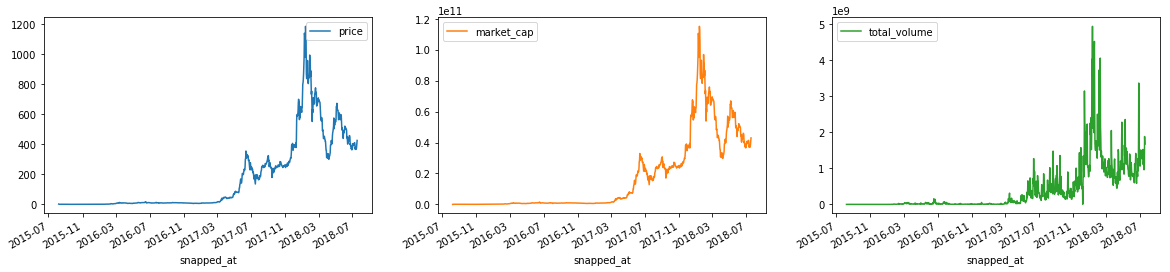

In [9]:
data[features].plot(subplots=True, layout=(1,3), figsize=(20,4));

In [10]:
data.iloc[0:10]

,price,market_cap,total_volume
snapped_at,,,
2015-08-07,2.580213,0.000000e+00,8.257608e+04
2015-08-08,1.175306,7.095505e+07,3.250759e+05
2015-08-10,0.624116,3.772033e+07,3.634980e+05
2015-08-11,0.966607,5.844581e+07,1.375588e+06
2015-08-12,1.126292,6.813006e+07,1.858814e+06
2015-08-13,1.636673,9.904778e+07,3.927292e+06
2015-08-14,1.643557,9.951063e+07,3.920484e+06
2015-08-15,1.505036,9.116528e+07,2.269451e+06
2015-08-16,1.329391,8.055977e+07,2.730304e+06


---
### Preprocessing Data

#### Complete the Index

The list is not complete _(2015-08-09 is missing)_ so we have to fill the blanks.

In [11]:
#check
'2015-08-09 00:00:00' in data.index

False

In [12]:
#Generate all the possible days and use them to reindex
start = data.index[data.index.argmin()]
end = data.index[data.index.argmax()]

index_complete = pd.date_range(start, end)
data = data.reindex(index_complete)

Now, the index is completed but the inexistent samples must be filled out.

#### Find NaN and Fix it

In [13]:
#Fill the blanks with the mean between the previous and the day after

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    day = data.loc[idx]
    if day.hasnans:
        #updating
        rg = slice(dayloc-1, dayloc+2)
        data.loc[idx] = data.iloc[rg].mean()
        
        print("Day <{}> updated".format(idx))

Day <2015-08-09 00:00:00> updated
Day <2017-04-02 00:00:00> updated


In [14]:
#check
data.loc['2015-08-09 00:00:00']

price           8.997108e-01
market_cap      5.433769e+07
total_volume    3.442869e+05
Name: 2015-08-09 00:00:00, dtype: float64

In [15]:
#Checking if we have NaN in another place
data[data.isnull().any(axis=1)].count()

price           0
market_cap      0
total_volume    0
dtype: int64

#### Closed Price Column

Now we need to include a new feature which will define the closed price for every sample. Ethereum market is always open so we can forget about weekends and use directly the open price of the next sample.

Afterwards the model will use this feature as the target since it's the value we try to predict.

The following script will help us with that.

In [16]:
new_column = 'closed_price'
datab = data.copy()

nc = list()

for idx in data.index:
    dayloc = data.index.get_loc(idx)
    
    #we put the price in the day after as closed price
    if dayloc == len(data.index)-1:
        #last position will not have closed_price
        closed_price = np.nan
    else:
        closed_price = data.iloc[dayloc+1].price
    
    nc.append(closed_price)

data[new_column] = nc
data.tail(5)

,price,market_cap,total_volume,closed_price
2018-07-14,368.662074,3.711445e+10,1.236705e+09,369.046271
2018-07-15,369.046271,3.716068e+10,9.606533e+08,382.453170
2018-07-16,382.453170,3.851854e+10,9.803516e+08,408.513921
2018-07-17,408.513921,4.115157e+10,1.881119e+09,426.688708
2018-07-18,426.688708,4.299124e+10,1.671871e+09,NaN


In [17]:
#Delete last because we don't know still the closed price 
data = data.drop(data.index[len(data)-1])

----
### Split Data into Training and Test Datasets

In [18]:
#X_train, X_test, y_train, y_test = train_test_split(data[features], 
#                                                    data.closed_price, 
#                                                    test_size=0.20,
#                                                    shuffle=False,
#                                                    random_state=42)

#80% for training
split = round(len(data)*0.9)
data_train, data_test = data[:split].copy(), data[split:].copy()

In [19]:
print("Size data_train: {}".format(data_train.shape[0]))
print("Size data_test: {}".format(data_test.shape[0]))

Size data_train: 968
Size data_test: 108


### Normalized Datasets

Take care of this because we __don't know if the future values are in the range__. For this reason we'll __fit the scaler using only the training data__ and not the testing data.

In [21]:
#Scale the data
scaler = StandardScaler()

data_train_norm, data_test_norm = data_train.copy(), data_test.copy()

data_train_norm[data.columns] = scaler.fit_transform(data_train[data.columns])
data_test_norm[data.columns] = scaler.transform(data_test[data.columns])

data_test_norm.describe()

,price,market_cap,total_volume,closed_price
count,108.000000,108.000000,108.000000,108.000000
mean,1.383300,1.444315,1.369351,1.385930
std,0.407437,0.415198,0.740381,0.403328
min,0.684706,0.714921,0.268275,0.683208
25%,1.092576,1.140382,0.895929,1.093271
50%,1.321660,1.391059,1.197582,1.320086
75%,1.679267,1.735312,1.696927,1.677650
max,2.291006,2.364537,5.208515,2.289316


---
## Building the Model

### Check Tensorflow and GPU

In [22]:
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer'
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0


/Users/samuel/anaconda/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:11: UserWarning: No GPU found. Please use a GPU to train your neural network.
  # This is added back by InteractiveShellApp.init_path()


### Regressor model

* 1 step and 3 features

In [23]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Flatten

X_train = data_train_norm[features].values.reshape((data_train_norm.shape[0], 1, 3))
y_train = data_train_norm.closed_price.values

X_test = data_test_norm[features].values.reshape((data_test_norm.shape[0], 1, 3))
y_test = data_test_norm.closed_price.values


Using TensorFlow backend.


In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(968, 1, 3)
(968,)
(108, 1, 3)
(108,)


In [25]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [26]:
print("Training R^2 score: {:.3f}".format(r2_score(y_train, model.predict(X_train))))

Training R^2 score: 0.992


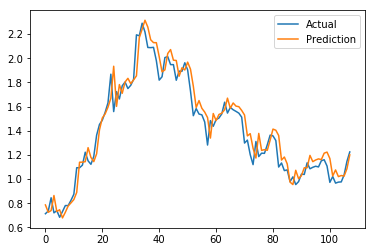

In [27]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [28]:
print("Testing R^2 score: {:.3f}".format(r2_score(y_test, pred)))

Testing R^2 score: 0.928


### Sequence model

* 7 steps and 3 features

In [29]:
'''
Helper function to transform the dataset to
shapes defined by 7 steps and 3 features
'''
def prepare_sequence(data, sequence_size=7):
    sequence = []
    buckets = data.shape[0]//sequence_size
    init_sample = data.shape[0] - buckets*sequence_size
    samples = 0
    for i in range(init_sample, data.shape[0] - sequence_size + 1):
        sequence.append(data[i:i+7])
        samples += 1
    return np.concatenate(sequence).reshape((samples, sequence_size, data.shape[1]))

prepare_sequence(data[features]).shape

(1065, 7, 3)

In [30]:
#getting (samples, steps, features)
X_train = prepare_sequence(data_train_norm[features])
X_test = prepare_sequence(data_test_norm[features])

y_train = data_train_norm.iloc[-len(X_train):].closed_price.values
y_test = data_test_norm.iloc[-len(X_test):].closed_price.values

In [31]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(960, 7, 3)
(960,)
(99, 7, 3)
(99,)


In [32]:
model = Sequential()
model.add(LSTM(32, input_shape=(7, 3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0)

In [33]:
print("Training R^2 score: {:.3f}".format(r2_score(y_train, model.predict(X_train))))

Training R^2 score: 0.993


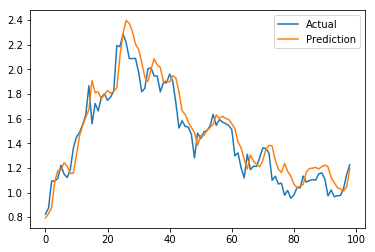

In [34]:
pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [35]:
print("Testing R^2 score: {:.3f}".format(r2_score(y_test, pred)))

Testing R^2 score: 0.880


### ⇩ __SPECIAL NORMALIZATION FOR SEQUENCES ⇩

The neural network is not able to get good predictions for that data that has not seen before. For that reason we can find day that are not well fitted. This problem is related to the __'out-of-scale'__ data inputs.

#### Custom: window steps by the rate of change ####

Thinking that the batch size is a window of days that defines how the neural network learns, one idea is to normalize the window by the last sample. On this way we'll be able to keep almost all data in the same scale.

In [36]:
def print_mean_std(data):
    mean = np.mean(data)
    std = np.std(data)
    print("mean:{:.3f} std:{:.3f}".format(mean, std))

In [37]:
def window_normalization(data, window_size):
    y = np.empty_like(data, dtype='float64')
    normalizer = list()
    for i in range(0,len(data), window_size):
        j = min(i+window_size, len(data))
        y[i:j] = data[i:j]/np.abs(data[j-1])
        normalizer.append(np.abs(data[j-1]))
        #print_mean_std(y[i:j])
        
    return y, normalizer

def window_denormalization(norm_data, normalizer, window_size):
    y = np.empty_like(norm_data, dtype='float64')
    idx = 0
    for i in range(0,len(norm_data), window_size):
        j = min(i+window_size, len(norm_data))
        y[i:j] = norm_data[i:j]*normalizer[idx]
        idx += 1
        
    return y

In [38]:
#testing the function
a = np.array([[1, 1, 1], [2, 2, 2], [2, 2, 2], [8, 8, 8]])
expected_result = np.array([[0.5, 0.5, 0.5], [1, 1, 1], [0.25, 0.25, 0.25], [1, 1, 1]])
norm_a, normalizer = window_normalization(a, 2)

assert ( np.array_equal(norm_a, expected_result) )
assert ( np.array_equal(a, window_denormalization(norm_a, normalizer, 2)) )

#### Standardization
There is another kind of normalization (specially robust for new values outside of the expected values.

_*__Note:__ this method assumes the distribution of data fits to Gaussian distribution._

In [39]:
from sklearn.preprocessing import StandardScaler

#global
def window_normalization_std(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data), scaler

def window_denormalization_std(norm_data, scaler):
    return scaler.inverse_transform(norm_data)

### Using Custom Normalization

In [40]:
#Showing the last sample
data.index[-1].strftime("%d-%m-%Y")

'17-07-2018'

In [41]:
window_size=32

X_train = data_train[features].values
y_train = data_train.closed_price.values

X_train_norm, _ = window_normalization(X_train, window_size)
y_train_norm, y_normalizer = window_normalization(y_train, window_size)

#getting (samples, steps, features)
X_train_norm = prepare_sequence(X_train_norm)
y_train_norm = y_train_norm[-len(X_train_norm):]

In [42]:
model = Sequential()
model.add(LSTM(32, input_shape=(7,3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_norm, y_train_norm, epochs=50, batch_size=window_size, verbose=0)

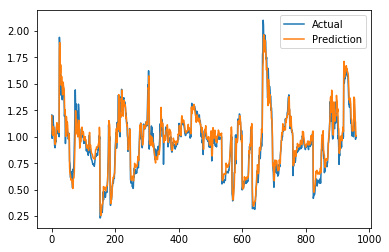

In [43]:
pred = model.predict(X_train_norm)
plt.plot(y_train_norm, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [44]:
print("Training R^2 score: {:.3f}".format(r2_score(y_train_norm, pred)))

Training R^2 score: 0.923


### Using Standardization
It seems the normalizer is not good enough, so since here we're testing the well known __standardization__ using the standard deviation thinking we have a Gaussina distribution.

In [45]:
window_size=32

X_train = data_train[features].values
y_train = data_train.closed_price.values

X_train_norm, _ = window_normalization_std(X_train)
y_train_norm, y_scaler = window_normalization_std(y_train.reshape(-1,1))

#getting (samples, steps, features)
X_train_norm = prepare_sequence(X_train_norm)
y_train_norm = y_train_norm[-len(X_train_norm):]

In [46]:
###
model = Sequential()
model.add(LSTM(32, input_shape=(7,3) ))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_norm, y_train_norm, epochs=50, batch_size=window_size, verbose=0)

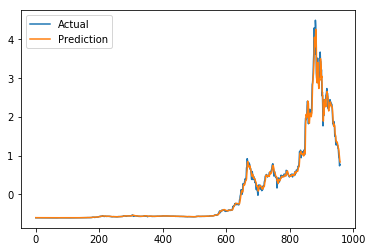

In [47]:
###
pred = model.predict(X_train_norm)
plt.plot(y_train_norm, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [48]:
print("Training R^2 score: {:.3f}".format(r2_score(y_train_norm, pred)))

Training R^2 score: 0.993


---
## Testing the Model

Seeing the last results our best chance of accurate predictions (__at a glance__) is to use:

* LSTM sequence by 7 steps and 3 features
* Data Standardization

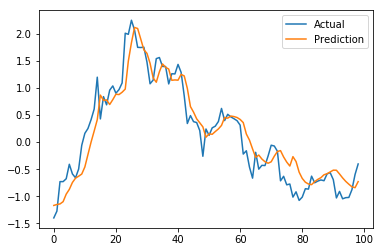

In [49]:
X_test = data_test[features].values
y_test = data_test.closed_price.values

X_test_norm, _ = window_normalization_std(X_test)
y_test_norm, y_scaler = window_normalization_std(y_test.reshape(-1,1))

#getting (samples, steps, features)
X_test_norm = prepare_sequence(X_test_norm)
y_test_norm = y_test_norm[-len(X_test_norm):]

pred = model.predict(X_test_norm)
plt.plot(y_test_norm, label='Actual')
plt.plot(pred, label='Prediction')
plt.legend()

In [50]:
print("Testing R^2 score: {:.3f}".format(r2_score(y_test_norm, pred)))

Testing R^2 score: 0.874


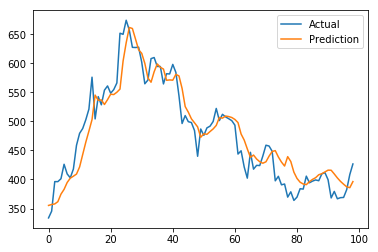

In [51]:
plt.plot(y_test[-len(X_test_norm):], label='Actual')
plt.plot(window_denormalization_std(pred, y_scaler), label='Prediction')
plt.legend()

## Conclusions

It seems the most accurate is the ~~sequence~~ model using normalization ~~by window size. Also it's truth the prediction value goes a few days ahead of the actual value.~~


---

__Log:__

1. ~~Added new method 'print_mean_std' to detect the stability of the data within the window size.~~
    
2. ~~It has been need to add a denormalization function to recover the real values after predictions. Probably it's not well defined and the algorithm should be re-checked (multiply by normalized number??)~~
    
3. ~~Testing doesn't have to be normalized.~~

4. ~~Next step, try to __recover original values__ in predictions.~~
5. ~~Normalization 2.~~
6. ~~Define a good metric. R2 score.~~
7. Changing steps from 7 to 3 or 14.